Loading and cleaning data...
Data ready: 5189 listings processed.
Training model...
Model Performance -> MAE: €47.66 | R²: 0.65
Generating visualizations...
- Saved feature_importance.png
- Saved correlation_heatmap.png
Generating map...
- Saved dublin_market_map.html
Done.


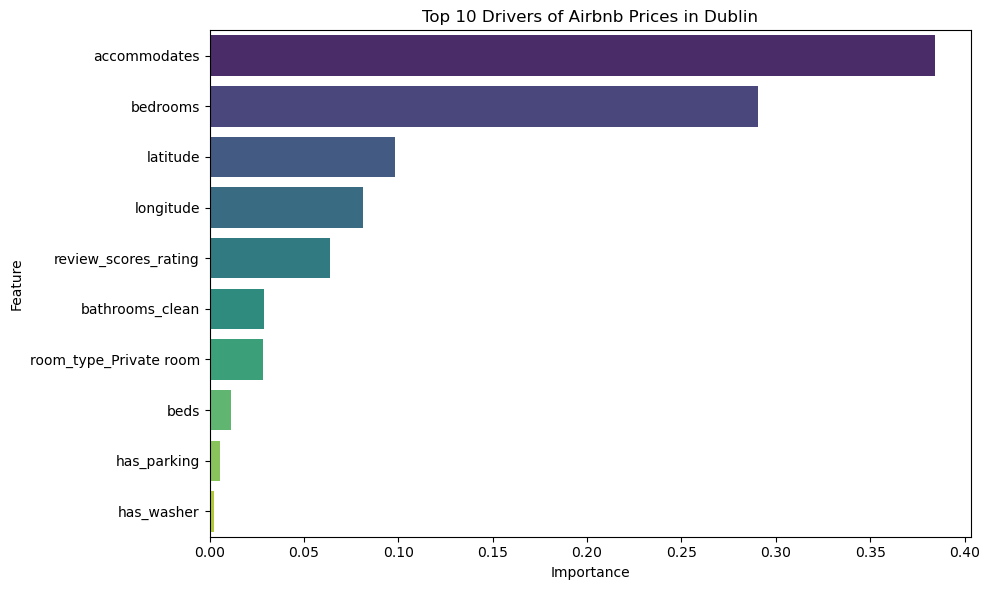

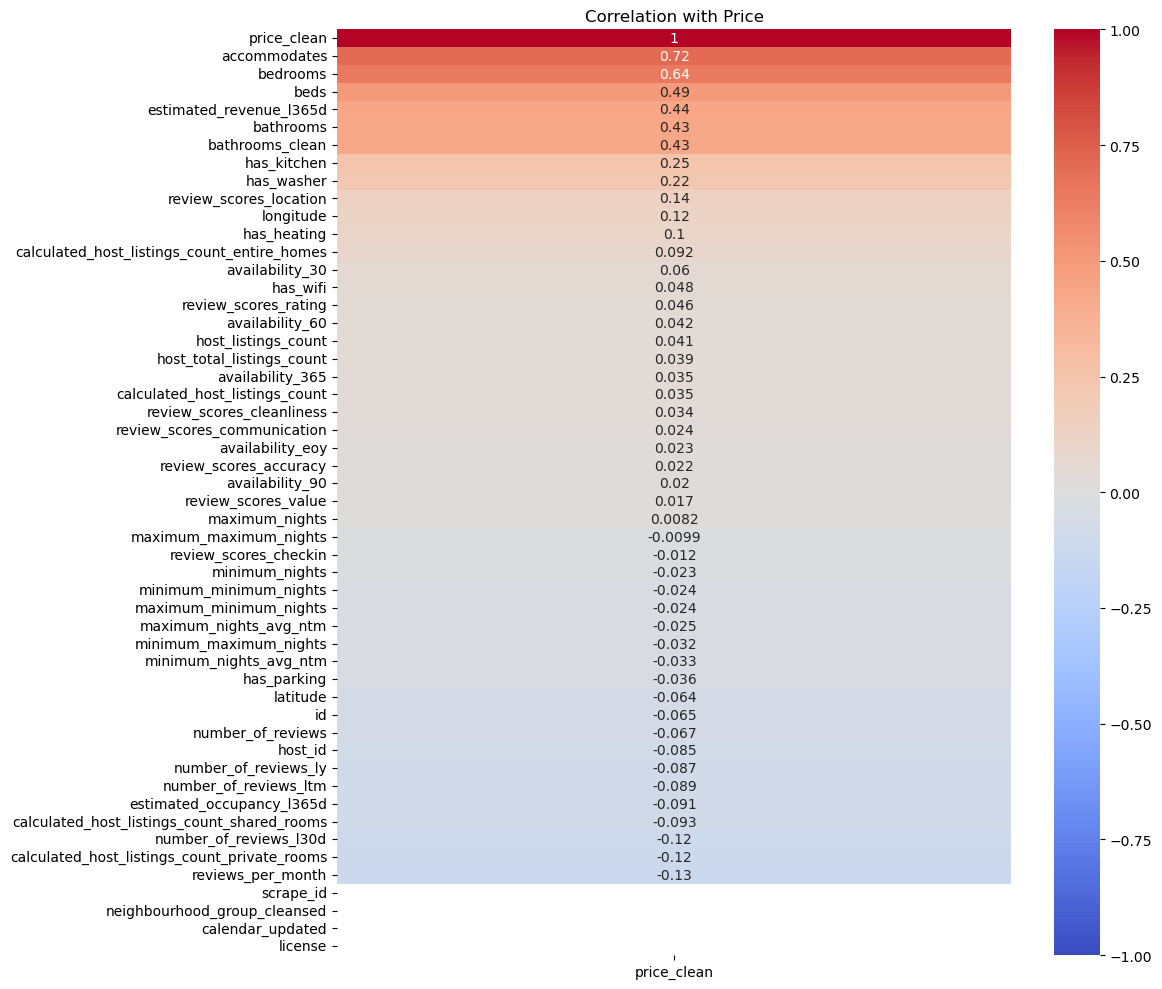

In [2]:
"""
Dublin Airbnb Fair Value Pricing Engine
---------------------------------------
A Machine Learning pipeline to estimate the fair market value of Airbnb listings 
in Dublin and identify undervalued/overpriced properties (arbitrage opportunities).

Outputs:
- dublin_market_map.html (Interactive Map)
- feature_importance.png (Bar Chart)
- correlation_heatmap.png (Heatmap)

Author: [Your Name]
Date: 2025-11-09
"""

import pandas as pd
import numpy as np
import ast
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import FastMarkerCluster
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Configuration
DATA_PATH = 'listings.csv'
OUTPUT_MAP_NAME = 'dublin_market_map.html'

def parse_amenities(amenity_str, target):
    """Parses the stringified list of amenities to check for a specific keyword."""
    try:
        amenity_list = ast.literal_eval(amenity_str)
        return 1 if any(target.lower() in item.lower() for item in amenity_list) else 0
    except (ValueError, SyntaxError):
        return 0

def load_and_clean_data(filepath):
    """Loads raw data and performs initial cleaning and feature engineering."""
    print("Loading and cleaning data...")
    df = pd.read_csv(filepath)
    
    # Clean Price
    df['price_clean'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    df = df.dropna(subset=['price_clean'])
    df = df[df['price_clean'] < 1000].copy()
    
    # Clean Bathrooms
    df['bathrooms_clean'] = df['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
    
    # Clean Beds
    df['beds'] = df['beds'].fillna(df['bedrooms'])
    
    # Feature Engineering
    amenities_map = {
        'has_wifi': 'wifi',
        'has_parking': 'parking',
        'has_kitchen': 'kitchen',
        'has_heating': 'heating',
        'has_washer': 'washer'
    }
    
    for col, keyword in amenities_map.items():
        df[col] = df['amenities'].apply(lambda x: parse_amenities(x, keyword))
        
    print(f"Data ready: {len(df)} listings processed.")
    return df

def train_model(df):
    """Trains a Random Forest Regressor and returns model + feature importance."""
    print("Training model...")
    
    numeric_features = [
        'accommodates', 'bedrooms', 'beds', 'bathrooms_clean', 'review_scores_rating',
        'latitude', 'longitude', 'has_wifi', 'has_parking', 
        'has_kitchen', 'has_heating', 'has_washer'
    ]
    categorical_features = ['room_type']
    
    # strict dropna for production quality
    df_model = df.dropna(subset=numeric_features).copy()
    
    X = pd.get_dummies(df_model[numeric_features + categorical_features], 
                       columns=categorical_features, drop_first=True)
    y = df_model['price_clean']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(
        n_estimators=500, min_samples_split=2, min_samples_leaf=4, 
        max_depth=None, random_state=42, n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    # Metrics
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"Model Performance -> MAE: €{mae:.2f} | R²: {r2:.2f}")
    
    return model, X, df_model, X_train.columns

def save_visualizations(model, feature_names, df_model):
    """Generates and saves the Heatmap and Feature Importance charts."""
    print("Generating visualizations...")
    
    # 1. Feature Importance Bar Chart
    importances = model.feature_importances_
    feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
    plt.title('Top 10 Drivers of Airbnb Prices in Dublin')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("- Saved feature_importance.png")
    
    # 2. Correlation Heatmap
    # Select only numeric columns for correlation
    numeric_cols = df_model.select_dtypes(include=[np.number]).columns
    corr = df_model[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr[['price_clean']].sort_values(by='price_clean', ascending=False), 
                annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation with Price')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    print("- Saved correlation_heatmap.png")

def generate_value_map(df, model, X):
    """Generates the HTML map."""
    print("Generating map...")
    df['predicted_price'] = model.predict(X)
    df['value_gap'] = df['predicted_price'] - df['price_clean']
    
    gems = df[df['value_gap'] > 30]
    traps = df[df['value_gap'] < -30]
    
    m = folium.Map(location=[53.3498, -6.2603], zoom_start=12, tiles='OpenStreetMap')
    
    gem_layer = folium.FeatureGroup(name='Undervalued Gems (Green)')
    for idx, row in gems.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5, color='green', fill=True, fill_color='lime', fill_opacity=0.6,
            popup=f"Price: €{row['price_clean']} | Value: €{int(row['predicted_price'])}"
        ).add_to(gem_layer)
    gem_layer.add_to(m)
    
    trap_layer = folium.FeatureGroup(name='Overpriced Traps (Red)')
    for idx, row in traps.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5, color='red', fill=True, fill_color='#ff4444', fill_opacity=0.6,
            popup=f"Overpriced by €{abs(int(row['value_gap']))}"
        ).add_to(trap_layer)
    trap_layer.add_to(m)
    
    folium.LayerControl().add_to(m)
    m.save(OUTPUT_MAP_NAME)
    print(f"- Saved {OUTPUT_MAP_NAME}")
    return gems, traps

if __name__ == "__main__":
    df_clean = load_and_clean_data(DATA_PATH)
    rf_model, X_features, df_processed, feature_cols = train_model(df_clean)
    save_visualizations(rf_model, feature_cols, df_processed)
    gems, traps = generate_value_map(df_processed, rf_model, X_features)
    print("Done.")